## Vectorizing a classic `for`-loop in NumPy for calculating Euclidean distances

<br>

One of the biggest advantages of NumPy, besides its convenient usage, is the speed gain over classic Python loop structures via vectorized arithmetic operations for its `ndarray` objects.

In general, "vectorizing" means that artithmetic operations on elments  in a vector can be done in parallel as an 1-step process. 
In theory, if we forget about additional overheads, a vectorized arithmetic addition, e.g.,

$\begin{pmatrix} 1 \\ 2 \\ 3 \\ 4 \end{pmatrix} + 1 = \begin{pmatrix} 1+1 \\ 2+1 \\ 3+1 \\ 4+1 \end{pmatrix} = \begin{pmatrix} 2 \\ 3 \\ 4 \\ 5\end{pmatrix}$

could be 4 times faster than adding the constant 1 to every number in sequential order.

In NumPy, some operations that are using the architecture's "BLAS" (Basic Linear Algebra Subroutines) can also take advantage of CPUs with multiple cores and run multiple processes in parallel, for example, the matrix dot product (`numpy.np(A,B)` or `A.dot(B)`).
Other array operations.

Other arithmetic operations in NumPy, e.g, arithmetic addition, don't make use of BLAS in the current implementation of NumPy. However, those are still overcoming Python's GIL (Global Interpreter Lock) to allow multi-threading (not to be confused with multi-processing), which can still result in a significant speed boost.  
<font size="1.2em">(Source: http://wiki.scipy.org/ParallelProgramming)</font>

### Euclidean Distance

For the following benchmarks, we will use a simple Euclidean distance calculation with the following equation  


\begin{equation} d = \sqrt{(X_1 - Y_1)^2 + (X_2 - Y_2)^2 + (X_3 - Y_3)^2 + ... (X_d - Y_d)}\end{equation}

But before we skip to the actual benchmark, let us visualize it for a set of 2 3D coordinates:

In [3]:
%matplotlib inline

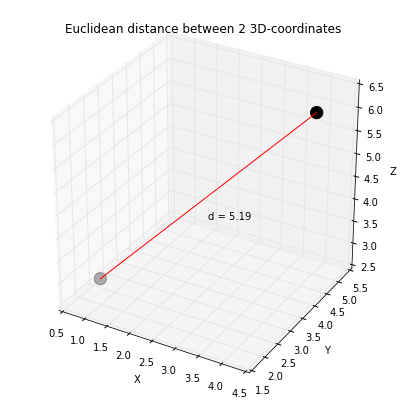

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
   

coords1 = [1, 2, 3]
coords2 = [4, 5, 6]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter((coords1[0], coords2[0]), 
        (coords1[1], coords2[1]),
        (coords1[2], coords2[2]),
         color="k", s=150)

ax.plot((coords1[0], coords2[0]), 
        (coords1[1], coords2[1]),
        (coords1[2], coords2[2]),
         color="r")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.text(x=2.5, y=3.5, z=4.0, s='d = 5.19')
      

plt.title('Euclidean distance between 2 3D-coordinates')

plt.show()        

### Python and NumPy Implementations

In [5]:
# Small sample data of 3D coordinates

coords1 = [1, 2, 3]
coords2 = [4, 5, 6]
np_c1 = np.array(coords1)
np_c2 = np.array(coords2)

In [6]:
# Classic For-loop

def eucldist_forloop(coords1, coords2):
    """ Calculates the euclidean distance between 2 lists of coordinates. """
    dist = 0
    for (x, y) in zip(coords1, coords2):
        dist += (x - y)**2
    return dist**0.5

In [7]:
# Generator expression

def eucldist_generator(coords1, coords2):
    """ Calculates the euclidean distance between 2 lists of coordinates. """
    return sum((x - y)**2 for x, y in zip(coords1, coords2))**0.5

In [8]:
# Vectorized version using NumPy

def eucldist_vectorized(coords1, coords2):
    """ Calculates the euclidean distance between 2 lists of coordinates. """
    return np.sqrt(np.sum((coords1 - coords2)**2))

In [9]:
# Using an in-built NumPy function

np.linalg.norm(np_c1 - np_c2)

5.196152422706632

In [10]:
print(eucldist_forloop(coords1, coords2))
print(eucldist_generator(coords1, coords2))
print(eucldist_vectorized(np_c1, np_c2))
print(np.linalg.norm(np_c1 - np_c2))

5.196152422706632
5.196152422706632
5.19615242271
5.19615242271


<br>
<br>

# `timeit` benchmarks

In [11]:
import timeit
import random
random.seed(123)

from numpy.linalg import norm as np_linalg_norm

funcs = ('eucldist_forloop', 'eucldist_generator', 'eucldist_vectorized', 'np_linalg_norm')
times = {f:[] for f in funcs}
orders_n = [10**i for i in range(1, 8)]
for n in orders_n:
    
    c1 = [random.randint(0,100) for _ in range(n)]
    c2 = [random.randint(0,100) for _ in range(n)]
    np_c1 = np.array(c1)
    np_c2 = np.array(c2)
    
    assert(eucldist_forloop(c1, c2) 
           == eucldist_generator(c1, c2)
           == eucldist_vectorized(np_c1, np_c2)
           == np_linalg_norm(np_c1 - np_c2)
           )
    
    times['eucldist_forloop'].append(min(timeit.Timer('eucldist_forloop(c1, c2)', 
            'from __main__ import c1, c2, eucldist_forloop').repeat(repeat=50, number=1)))
    times['eucldist_generator'].append(min(timeit.Timer('eucldist_generator(c1, c2)', 
            'from __main__ import c1, c2, eucldist_generator').repeat(repeat=50, number=1)))
    times['eucldist_vectorized'].append(min(timeit.Timer('eucldist_vectorized(np_c1, np_c2)', 
            'from __main__ import np_c1, np_c2, eucldist_vectorized').repeat(repeat=50, number=1)))    
    times['np_linalg_norm'].append(min(timeit.Timer('np_linalg_norm(np_c1 - np_c2)', 
            'from __main__ import np_c1, np_c2, np_linalg_norm').repeat(repeat=50, number=1))) 

In [45]:
labels = {'eucldist_forloop': 'for-loop',
          'eucldist_generator': 'generator expression (comprehension equiv.)',
          'eucldist_vectorized': 'NumPy vectorization',
          'np_linalg_norm': 'numpy.linalg.norm'
          }

def plot(times, orders_n, labels):

    colors = ('cyan', '#7DE786', 'black', 'blue') 
    linestyles = ('-', '-', '--', '--')
    fig = plt.figure(figsize=(11,10))
    for lb,c,l in zip(labels.keys(), colors, linestyles):
        plt.plot(orders_n, times[lb], alpha=1, label=labels[lb], 
                 lw=3, color=c, linestyle=l)
    plt.xlabel('sample size n (items in the list)', fontsize=14)
    plt.ylabel('time per computation in seconds', fontsize=14)
    plt.xlim([min(orders_n) / 10, max(orders_n)* 10])
    plt.legend(loc=2, fontsize=14)
    plt.grid()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Python for-loop/generator expr. vs. NumPy vectorized code', fontsize=18)
    plt.show()

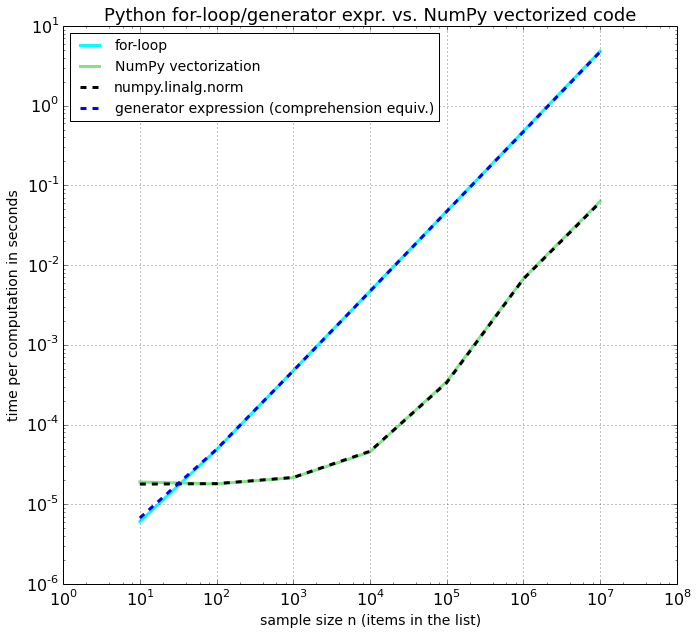

In [46]:
plot(times, orders_n, labels)

As we can see in the plot, the vectorized code runs a lot faster than our classic Python `for`-loop (note that this graph is plotted on logarithmic scale).

# References

- https://nbviewer.org/github/rasbt/One-Python-benchmark-per-day/blob/master/ipython_nbs/day16_numpy_vectorization.ipynb